In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score


In [ ]:
df = pd.read_csv('CTLT.csv')


In [ ]:
#chuyển đổi logarit -->  giảm ảnh hưởng của giá trị ngoại lai và cải thiện phân phối dữ liệu cho biến mục tiêu (giá đóng cửa). 
df['Log_Close'] = np.log(df['Close'])


In [ ]:
df = df.dropna()


In [ ]:
train_ratio = 0.7
test_ratio = 0.2
validation_ratio = 0.1

In [ ]:
data = df.sort_values('Date')
n_samples = len(data)


In [ ]:

# Calculate statistics
n_samples = len(df)
close_price = df['Log_Close']
maximum = close_price.max()
minimum = close_price.min()
average = close_price.mean()
median = close_price.median()
mode = close_price.mode().values
quantile = close_price.quantile([0.25, 0.5, 0.75]).values
variance = close_price.var()
std = close_price.std()
coef_var = std / average
coef_skewness = close_price.skew()
coef_kurtosis = close_price.kurtosis()

# Print results
print("Information of Close Price")
print("Number Of Lines: ", n_samples)
print("Maximum:", maximum)
print("Minimum:", minimum)
print("Average:", average)
print("Median:", median)
print("Mode: ", mode)
print("Quantile: ", quantile)
print("Variance: ", variance)
print("Standard deviation: ", std)
print("Coefficient of Variation: ", coef_var)
print("Coefficient of Skewness: ", coef_skewness)
print("Coefficient of Kurtosis: ", coef_kurtosis)


Information of Close Price
Number Of Lines:  1084
Maximum: 4.958288855873677
Minimum: 3.3958497753355603
Average: 4.326768345236818
Median: 4.424906477470909
Mode:  [3.88424064 3.94352163 4.69692862]
Quantile:  [3.95599205 4.42490648 4.6676754 ]
Variance:  0.15164154516748204
Standard deviation:  0.38941179382176144
Coefficient of Variation:  0.09000061079083439
Coefficient of Skewness:  -0.2598357878184362
Coefficient of Kurtosis:  -1.2837284773636646


In [ ]:
train_data = data.iloc[:int(n_samples * train_ratio)]
validation_data = data.iloc[int(n_samples * train_ratio):int(n_samples * (train_ratio + validation_ratio))]
test_data = data.iloc[int(n_samples * (train_ratio + validation_ratio)):]

In [ ]:
X_train = train_data.drop(['Date', 'Close', 'Adj Close','Log_Close'], axis=1)
y_train = train_data['Log_Close']

X_val = validation_data.drop(['Date', 'Close', 'Adj Close','Log_Close'], axis=1)
y_val = validation_data['Log_Close']

X_test = test_data.drop(['Date', 'Close', 'Adj Close','Log_Close'], axis=1)
y_test = test_data['Log_Close']

In [ ]:
X_test

,Open,High,Low,Volume
867,107.730003,108.739998,106.010002,1249900
868,103.400002,104.150002,101.019997,1218900
869,103.010002,104.870003,101.820000,1032000
870,105.680000,106.769997,103.629997,880200
871,102.989998,103.574997,100.250000,790600
...,...,...,...,...
1079,46.009998,49.860001,42.529999,14629300
1080,45.200001,45.375000,41.509998,10057000
1081,41.419998,43.669998,41.330002,6744900
1082,42.660000,44.410000,42.259998,3464300


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
gbt = GradientBoostingRegressor(random_state=42)


In [ ]:
param_dist = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [2, 3, 4, 5, 6],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}


In [ ]:
random_search = RandomizedSearchCV(gbt, param_distributions=param_dist, n_iter=50, cv=5, scoring='neg_mean_squared_error', verbose=1, random_state=42)
random_search.fit(X_train_scaled, y_train)

print("Best parameters found: ", random_search.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.8, 'n_estimators': 250, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.2}


In [ ]:
best_gbt = random_search.best_estimator_

In [ ]:
y_pred_train = best_gbt.predict(X_train_scaled)
y_pred_val = best_gbt.predict(X_val_scaled)
y_pred_test = best_gbt.predict(X_test_scaled)

mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mse_val = mean_squared_error(y_val, y_pred_val)
rmse_val = np.sqrt(mse_val)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)


In [ ]:
print(f"RMSE on training set: {rmse_train:.4f}")
print(f"RMSE on validation set: {rmse_val:.4f}")
print(f"RMSE on test set: {rmse_test:.4f}")


RMSE on training set: 0.0013
RMSE on validation set: 0.0138
RMSE on test set: 0.0198


In [ ]:
# Calculate Mean Absolute Error (MAE)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_val = mean_absolute_error(y_val, y_pred_val)
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f"Mean Absolute Error on training set: {mae_train:.4f}")
print(f"Mean Absolute Error on validation set: {mae_val:.4f}")
print(f"Mean Absolute Error on test set: {mae_test:.4f}")

# Calculate R-squared (R2)
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)
r2_test = r2_score(y_test, y_pred_test)

print(f"R-squared on training set: {r2_train:.4f}")
print(f"R-squared on validation set: {r2_val:.4f}")
print(f"R-squared on test set: {r2_test:.4f}")

Mean Absolute Error on training set: 0.0011
Mean Absolute Error on validation set: 0.0113
Mean Absolute Error on test set: 0.0148
R-squared on training set: 1.0000
R-squared on validation set: 0.9602
R-squared on test set: 0.9964


#Trực quan hoá kết quả train model

In [ ]:
import matplotlib.dates as mdates

# Lấy ngày từ dữ liệu
dates_train = pd.to_datetime(train_data['Date'])
dates_val = pd.to_datetime(validation_data['Date'])
dates_test = pd.to_datetime(test_data['Date'])

# Dự đoán giá trị
y_pred_train = best_gbt.predict(X_train_scaled)
y_pred_val = best_gbt.predict(X_val_scaled)
y_pred_test = best_gbt.predict(X_test_scaled)

# Chuyển đổi dự đoán từ logarit về giá trị thực
y_pred_train_exp = np.exp(y_pred_train)
y_pred_val_exp = np.exp(y_pred_val)
y_pred_test_exp = np.exp(y_pred_test)


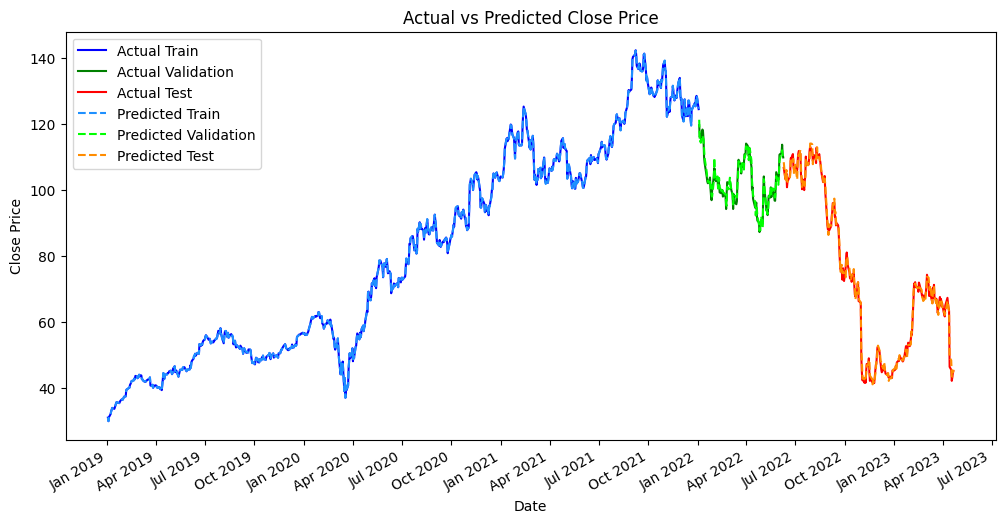

In [ ]:
# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dates_train, np.exp(y_train), label='Actual Train', color='blue')
ax.plot(dates_val, np.exp(y_val), label='Actual Validation', color='green')
ax.plot(dates_test, np.exp(y_test), label='Actual Test', color='red')

ax.plot(dates_train, y_pred_train_exp, label='Predicted Train', color='dodgerblue', linestyle='--')
ax.plot(dates_val, y_pred_val_exp, label='Predicted Validation', color='lime', linestyle='--')
ax.plot(dates_test, y_pred_test_exp, label='Predicted Test', color='darkorange', linestyle='--')

ax.set(xlabel='Date', ylabel='Close Price', title='Actual vs Predicted Close Price')
ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate()
plt.show()

In [ ]:
# Predict stock prices for the next 30 days
X_future = X_test_scaled[-30:]
y_future_pred = best_gbt.predict(X_future)


In [ ]:
y_future_pred

array([4.24484551, 4.18282012, 4.23584617, 4.24376505, 4.25999039,
       4.21404269, 4.18350253, 4.20396286, 4.19271557, 4.14394298,
       4.12855876, 4.19097613, 4.20006913, 4.1989955 , 4.19978174,
       4.17318799, 4.14457052, 4.14683685, 4.12767118, 4.13878399,
       4.1941498 , 4.18815892, 4.16069309, 4.14317025, 3.89343572,
       3.87772038, 3.774671  , 3.76887677, 3.78852989, 3.81677396])

In [ ]:
# Convert predicted log prices to actual prices
y_future_pred_actual = np.exp(y_future_pred)


In [ ]:
y_future_pred_actual

array([69.74498437, 65.55045283, 69.12014117, 69.66966848, 70.80930313,
       67.62939227, 65.59520041, 66.95112369, 66.20232397, 63.05094025,
       62.08837442, 66.08726941, 66.69094093, 66.61937839, 66.67177765,
       64.92209352, 63.09052011, 63.23366601, 62.03329036, 62.72649899,
       66.29734158, 65.90134941, 64.11594543, 63.00223799, 49.07921988,
       48.31395207, 43.58316692, 43.33136624, 44.19138615, 45.45732456])

In [ ]:
# Print predicted stock prices for the next 30 days
for i in range(len(y_future_pred_actual)):
    print(f"Predicted stock price on day {i+1}: {y_future_pred_actual[i]:.2f}")


Predicted stock price on day 1: 69.74
Predicted stock price on day 2: 65.55
Predicted stock price on day 3: 69.12
Predicted stock price on day 4: 69.67
Predicted stock price on day 5: 70.81
Predicted stock price on day 6: 67.63
Predicted stock price on day 7: 65.60
Predicted stock price on day 8: 66.95
Predicted stock price on day 9: 66.20
Predicted stock price on day 10: 63.05
Predicted stock price on day 11: 62.09
Predicted stock price on day 12: 66.09
Predicted stock price on day 13: 66.69
Predicted stock price on day 14: 66.62
Predicted stock price on day 15: 66.67
Predicted stock price on day 16: 64.92
Predicted stock price on day 17: 63.09
Predicted stock price on day 18: 63.23
Predicted stock price on day 19: 62.03
Predicted stock price on day 20: 62.73
Predicted stock price on day 21: 66.30
Predicted stock price on day 22: 65.90
Predicted stock price on day 23: 64.12
Predicted stock price on day 24: 63.00
Predicted stock price on day 25: 49.08
Predicted stock price on day 26: 4

In [ ]:
num_days = 30
latest_input = y_test.iloc[-30:].copy() # Lấy 30 ngày gần nhất từ tập test
predictions = []

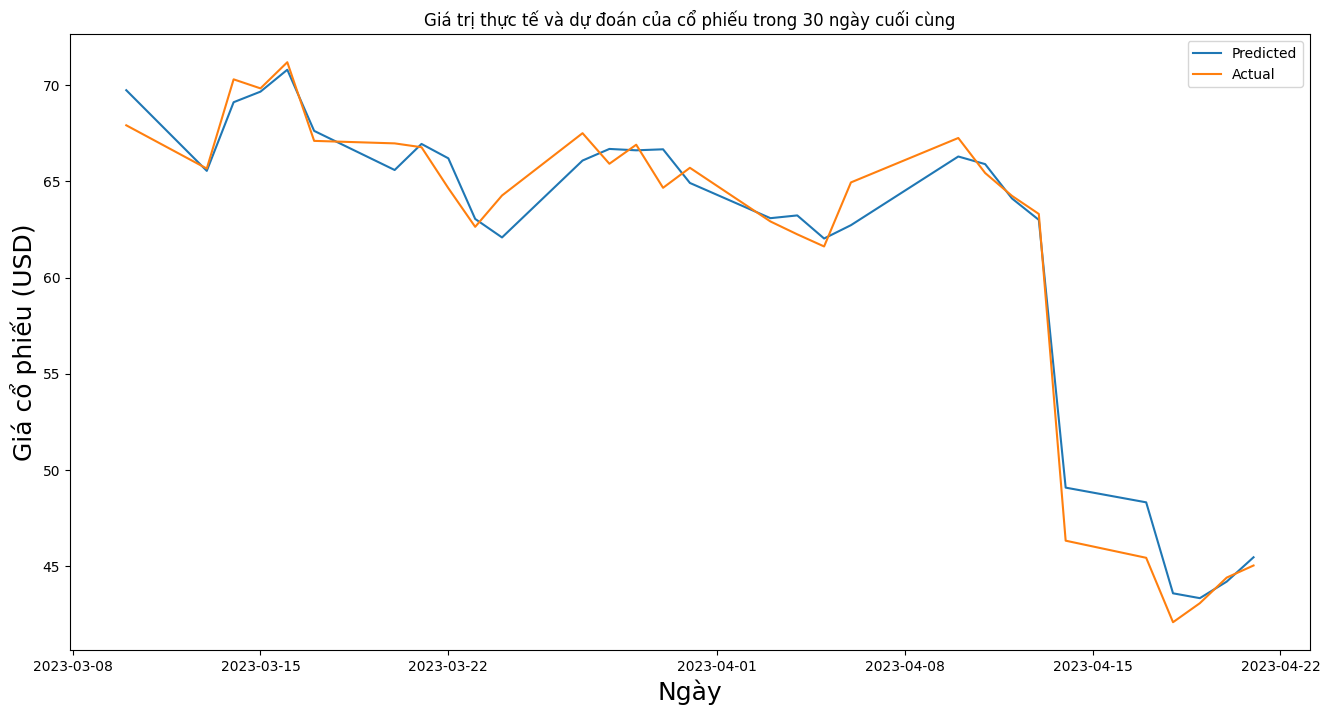

In [ ]:
# Trực quan hoá giá trị thực tế và dự đoán của cổ phiếu trong 30 ngày cuối cùng
plt.figure(figsize=(16,8))
plt.title('Giá trị thực tế và dự đoán của cổ phiếu trong 30 ngày cuối cùng')
plt.plot([d.date() for d in pd.to_datetime(df['Date'][-30:])], np.exp(y_future_pred), label='Predicted')
plt.plot([d.date() for d in pd.to_datetime(df['Date'][-30:])], df['Close'][-30:], label='Actual')
plt.xlabel('Ngày', fontsize=18)
plt.ylabel('Giá cổ phiếu (USD)', fontsize=18)
plt.legend()
plt.show()
